# The examples of usage CSAPS


In [71]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import csaps


## Univariate smoothing


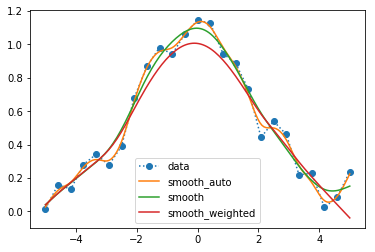

In [72]:
np.random.seed(1234)

x = np.linspace(-5., 5., 25)
y = np.exp(-(x/2.5)**2) + (np.random.rand(25) - 0.2) * 0.3

w = np.ones_like(x)
w[8:16] = 0.1
w[-3:] = 0.01

smooth = 0.85

sp_a = csaps.UnivariateCubicSmoothingSpline(x, y)
sp_s = csaps.UnivariateCubicSmoothingSpline(x, y, smooth=smooth)
sp_w = csaps.UnivariateCubicSmoothingSpline(x, y, w, smooth=smooth)

xi = np.linspace(x[0], x[-1], 150)

yi_a = sp_a(xi)
yi_s = sp_s(xi)
yi_w = sp_w(xi)

plt.plot(x, y, 'o:', xi, yi_a, '-', xi, yi_s, '-', xi, yi_w, '-')
plt.legend(['data', 'smooth_auto', 'smooth', 'smooth_weighted']);


### Vectorization


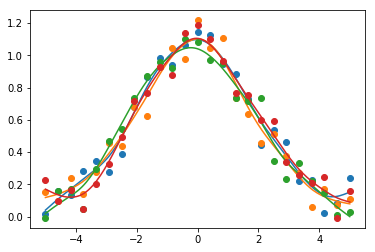

In [73]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color'][:4]

np.random.seed(1234)

x = np.linspace(-5., 5., 25)
y = np.exp(-(x/2.5)**2) + (np.random.rand(len(colors), 25) - 0.2) * 0.3

sp = csaps.UnivariateCubicSmoothingSpline(x, y, smooth=smooth)

xi = np.linspace(x[0], x[-1], 150)
yi = sp(xi)

for y_i, yi_i, c_i in zip(y, yi, colors):
    plt.plot(x, y_i, 'o', color=c_i)
    plt.plot(xi, yi_i, '-', color=c_i)


## Multivariate smoothing

The algorithm can make multivariate smoothing splines for ND-gridded data approximation.
In this case we use coordinatewise smoothing (tensor-product of univariate splines coefficients).

### Smoothing a surface (bivariate)


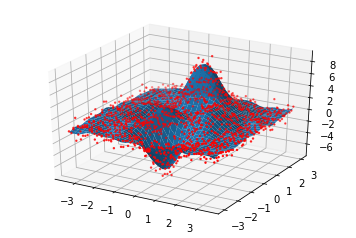

In [74]:
from mpl_toolkits.mplot3d import Axes3D

import csaps

xdata = [np.linspace(-3, 3, 41), np.linspace(-3.5, 3.5, 31)]
i, j = np.meshgrid(*xdata, indexing='ij')

ydata = (3 * (1 - j)**2. * np.exp(-(j**2) - (i + 1)**2)
         - 10 * (j / 5 - j**3 - i**5) * np.exp(-j**2 - i**2)
         - 1 / 3 * np.exp(-(j + 1)**2 - i**2))

np.random.seed(12345)
noisy = ydata + (np.random.randn(*ydata.shape) * 0.75)

sp = csaps.MultivariateCubicSmoothingSpline(xdata, noisy, smooth=0.988)
ysmth = sp(xdata)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(j, i, noisy, s=2, c='r')

ax.plot_surface(j, i, ysmth, linewidth=0, alpha=1.0);
